<a href="https://colab.research.google.com/github/sai-teja-ponugoti/Machine-Learning-Concepts/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing required moduels
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
# do not use disable_progress_bar function if you want to know the progress of data preproessing steps 
tfds.disable_progress_bar()

**Data preprocessing**

In [0]:
# importing the cats_vs_dogs tensorflow inbuilt dataset and splitting the data using load() function
# train data = 80%, validation = 10% and test = 10%
(train_raw, validation_raw, test_raw), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [39]:
print(raw_train)
print(raw_validation)
print(raw_test)
print(metadata)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD

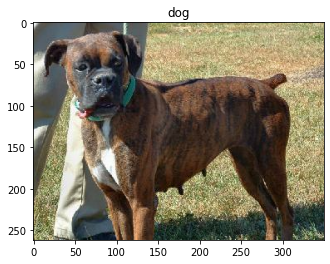

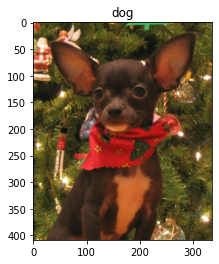

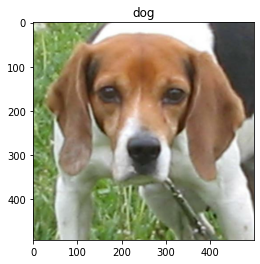

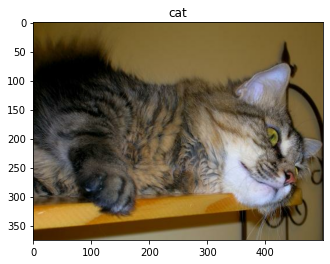

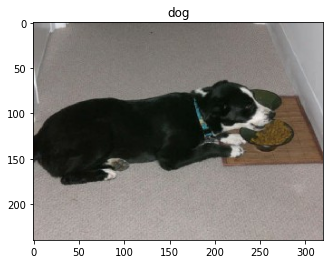

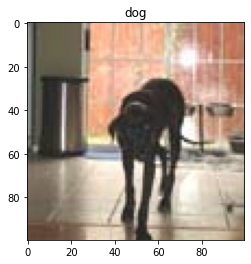

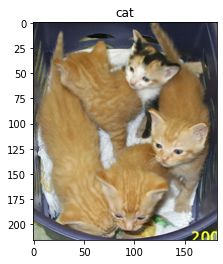

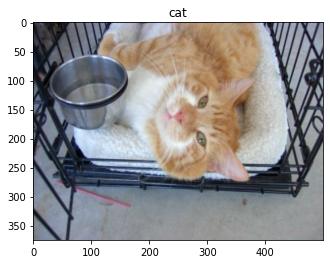

In [67]:
# getting label names
get_label_name = metadata.features['label'].int2str
# print(get_label_name)
for image, label in raw_train.take(8):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

**Format the Data**

In [0]:
# any image size can be selected
IMG_SIZE = 224 # All images will be resized to 224x224x3

def image_formatting(image, label):
    # converting pixel values to float type
    image = tf.cast(image, tf.float32)
    # normalising the data to be in range of -1 tp +1 255/2 = 127.5
    image = (image/127.5) - 1
    # resizing all images to a shape of 224x*224*3
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
#converting all images to same shape and formatting them for quicker training of the model
train = train_raw.map(format_example)
validation = validation_raw.map(format_example)
test = test_raw.map(format_example)

Apply this function to each item in the dataset using the map method:

In [70]:
print(train_raw)
print(validation_raw)
print(test_raw)
# print(metadata)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [73]:
# checking the batch formation
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape
# expected size (batch_size,160*160*3)

TensorShape([32, 224, 224, 3])

Create the base model from the pre-trained convnets.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [74]:
# from keras.applications.resnet50 import ResNet50
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [75]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [0]:
base_model.trainable = False

In [77]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [78]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [79]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
len(model.trainable_variables)

2

In [0]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 1s 53ms/step - loss: 0.8678 - accuracy: 0.3688


In [0]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.37


In [0]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 50s 86ms/step - loss: 0.2298 - accuracy: 0.8968 - val_loss: 0.0897 - val_accuracy: 0.9708
Epoch 2/10
582/582 [==============================] - 49s 85ms/step - loss: 0.0720 - accuracy: 0.9752 - val_loss: 0.0647 - val_accuracy: 0.9789
Epoch 3/10
582/582 [==============================] - 50s 86ms/step - loss: 0.0577 - accuracy: 0.9797 - val_loss: 0.0569 - val_accuracy: 0.9811
Epoch 4/10
582/582 [==============================] - 49s 85ms/step - loss: 0.0517 - accuracy: 0.9810 - val_loss: 0.0528 - val_accuracy: 0.9811
Epoch 5/10
582/582 [==============================] - 52s 90ms/step - loss: 0.0484 - accuracy: 0.9826 - val_loss: 0.0504 - val_accuracy: 0.9807
Epoch 6/10
582/582 [==============================] - 50s 86ms/step - loss: 0.0461 - accuracy: 0.9832 - val_loss: 0.0490 - val_accuracy: 0.9811
Epoch 7/10
582/582 [==============================] - 50s 85ms/step - loss: 0.0444 - accuracy: 0.9839 - val_loss: 0.0479 - val_accuracy:

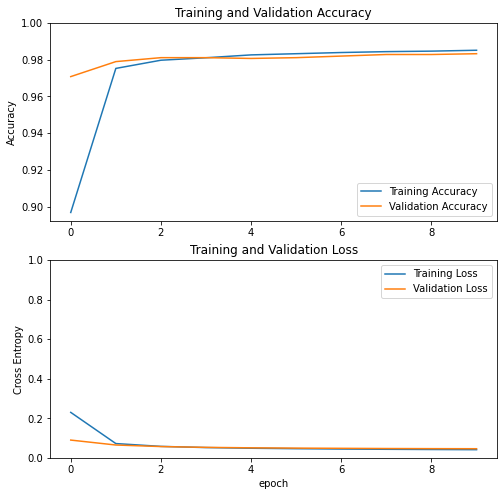

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine tuning**

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 55s 95ms/step - loss: 0.1187 - accuracy: 0.9562 - val_loss: 0.0799 - val_accuracy: 0.9781
Epoch 11/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0636 - accuracy: 0.9749 - val_loss: 0.0551 - val_accuracy: 0.9828
Epoch 12/20
582/582 [==============================] - 56s 97ms/step - loss: 0.0494 - accuracy: 0.9818 - val_loss: 0.0493 - val_accuracy: 0.9828
Epoch 13/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0386 - accuracy: 0.9843 - val_loss: 0.0496 - val_accuracy: 0.9837
Epoch 14/20
582/582 [==============================] - 55s 94ms/step - loss: 0.0298 - accuracy: 0.9877 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 15/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0243 - accuracy: 0.9914 - val_loss: 0.0504 - val_accuracy: 0.9828
Epoch 16/20
582/582 [==============================] - 55s 94ms/step - loss: 0.0190 - accuracy: 0.9927 - val_loss: 0.0522 - val_ac